In [1]:
from __future__ import print_function
import mrcnn
import json
import os
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from io import BytesIO
from PIL import Image
import numpy as np
import matplotlib.patches as patches
from mrcnn.visualize import random_colors, apply_mask, find_contours
import matplotlib.image as mpimg
from scipy.misc import toimage, imsave
from skimage import io
import glob
import skimage
from skimage import measure
from shapely.geometry import Polygon, MultiPolygon
import urllib.request


In [2]:
ROOT = "/home/maxsen/git/master_thesis/data/"
DATA = "/home/maxsen/DEEPL/data/"

## Functions from matterport maskrcnn

In [3]:
# download images to chunk them
def download_img(anno_file, img_dir):
    
    anno = json.load(open(anno_file))
    for s in anno:
        name = s['External ID']
        url = s['Labeled Data']
        urllib.request.urlretrieve(url, img_dir + name)
        print('downloading %s'%(name))


In [4]:
# parse the json file with segmented info and link to the cloud storage
# with the images

def labelbox_annotations_parser(annotations_dir,annotation_file,img_size):
    
    """
    Remember that for labelbox:
    - origin (0,0) of the reference system in bottom left corner like
    cartesian system
    - labelbox can label objects outside the image so the coords
    need to be trimmed to the image size
    - This parser consider that all the images are square and same image size
    
    """
    
    annotations = json.load(open(annotations_dir+annotation_file))
    
    # Parse the annotation of the images done using labelbox.io
    # into a better formatted dict
    # Check with the company  where is the origin

    # create incremental number for all the identified objects
    obj_idx = 0


    # create a labels list
    labels_list = [] 
    labels_dict = {}

    # Reformatted dict
    annotations_dict = {}


    # Masks reference
    masks_urls_dict = {}

    # Loop through all the images
    # TODO: Check to skip non annotated images 
    for annotation_data in annotations:

        # Avoid error when empty images
        if isinstance(annotation_data['Label'],dict):
        # save the image id
            img_id = annotation_data['External ID']
            annotations_dict[img_id] = {}
            masks_urls_dict[img_id] = {}


            # create subdict with labels
            for lab in annotation_data['Label'].keys():
                if lab not in labels_list:
                    labels_list.append(lab) 
                annotations_dict[img_id][lab] = {}

            # Create labels dict with reference number starting from 1
            # because zero is for background
            lab_idx = 1
            for lab in labels_list:
                labels_dict[lab] = lab_idx
                lab_idx += 1

            # loop through the labels and convert the coords in a list of tuples
            for lab, objs in annotation_data['Label'].items():
                for obj_coords in objs:
                    coords = [tuple(coord_pair.values()) for coord_pair in obj_coords]
                
                    # Convert the coords in numpy array
                    coords = np.array(coords)
                    # labelbox reference system has (0,0) on the bottom left corner
                    # need to correct in order to have skimage system
                
                    # Flip cartesian y-axis
                    coords = np.abs(coords-np.array([0,img_size]))
                
                    # Swap x,y converting to [rr,cc] system
                    coords[:,[0,1]] = coords[:,[1,0]]
                
                    # Remove values that are ouside the range
                    #Remove points below 0
                    coords[coords<0] = 0
                
                    # Remove the point out of the upper limit of the edges
                    coords[coords>img_size] = img_size
                
                
                    annotations_dict[img_id][lab][obj_idx] = coords
                    obj_idx +=1

        
#        # Collect all the url for the masks
#        for lab in annotation_data['Masks'].keys():
#            masks_urls_dict[img_id][lab] = annotation_data['Masks'][lab]
            
    return annotations_dict, masks_urls_dict, labels_dict

# The function can be parallelized
def chunking_labeled_images(number_chunks_dimension,class_names, img_raw,chunked_dir,annotations_dict):


    # Get image ids from annotations
    image_ids = list(annotations_dict.keys())

    for image_id in image_ids:

        # Define the image path
        image_path = img_raw + image_id

        # segmented regions
        polygons = annotations_dict[image_id]


        # Determine the size of the image
        image = skimage.io.imread(image_path)
        
        # Convert the image to uint8
        image = skimage.util.img_as_ubyte(image)
        # image = skimage.color.grey2rgb(image)
        height, width = image.shape[:2]


        # Load and create masks array

        # Determine how many objects of the different classes have been segmented
        instance_count = 0
        for lab in polygons:
            instance_count += len(list(polygons[lab].values()))

        mask = np.zeros([height, width, instance_count],
                        dtype=np.uint8)


        class_ids = []
        mask_layer = 0
        for lab, pgs in polygons.items():

            # Get the class id
            class_id = class_names.index(lab)

            for obj_num, coords in pgs.items():

                rr, cc = skimage.draw.polygon(coords[:,0], coords[:,1])
                mask[rr, cc, mask_layer] = class_id
                mask_layer += 1
                class_ids.append(class_id)


        class_ids = np.array(class_ids)


        # stack image with masks
        image_mask = np.insert(mask,0,image,axis=2)


        # consider that we are collecting square images and only even number of cuts
        hsplits = np.split(image_mask,number_chunks_dimension,axis=0)
        total_images = []
        for split in hsplits:
                total_images.append(np.split(split,number_chunks_dimension,axis=1))
        total_images = [img for cpl in total_images for img in cpl] 

        # Chunk the images and the segmented data
        for idx,image_chunk in enumerate(total_images):
            image_chunks_ids = []
            mask = image_chunk != 0
            planes_to_keep = np.flatnonzero((mask).sum(axis=(0,1)))
            # Make sure that the image has labeled objects
            if planes_to_keep.size:
                image_chunk_trimmed = image_chunk[:,:,planes_to_keep]
                image_chunk_trimmed_id = image_id.split('.')[0]+'chunk'+str(idx)

                np.save(chunked_dir + image_chunk_trimmed_id, image_chunk_trimmed)


## Functions

In [5]:
# make sub mask
def make_sub_masks(np_array):

    
    sub_masks = {}
    
    width, height, dim = np_array.shape
    
    # go through the np.array pixel-wise
    for x in range(width):
        for y in range(height):
            
            # Get the pixel values from the numpy array
            a = np_array[x,y,0]
            b = np_array[x,y,1]
            c = np_array[x,y,2]
            # get pixel in RGB format
            pixel = (a,b,c)
            
            # if pixel is not background/black
            if pixel != (0,0,0):
                pixel_str = str(pixel)
                sub_mask = sub_masks.get(pixel_str)
                
                if sub_mask is None:
                    
                    # Create a sub-mask (one bit per pixel) and add to the dictionary
                    # Note: we add 1 pixel of padding in each direction
                    # because the contours module doesn't handle cases
                    # where pixels bleed to the edge of the image
                    
                    sub_masks[pixel_str] = Image.new('1', (width+2, height+2))

                # Set the pixel value to 1 (default is 0), accounting for padding
                sub_masks[pixel_str].putpixel((x+1, y+1), 1)
    
    return sub_masks

In [8]:
# make annotation for mask
def create_sub_mask_annotation(sub_mask, image_id, category_id, annotation_id, is_crowd = 0):
    
    # Find contours (boundary lines) around each sub-mask
    # Note: there could be multiple contours if the object
    # is partially occluded. (E.g. an elephant behind a tree)
    contours = measure.find_contours(sub_mask, 0.5, positive_orientation = "low")
    
    segmentations = []
    polygons = []

    for contour in contours:
        # Flip from (row, col) representation to (x, y)
        # and subtract the padding pixel
        for i in range(len(contour)):
            row, col = contour[i]
            contour[i] = (col - 1, row - 1)

        # Make Polygon and simplify it
        poly = Polygon(contour)
        poly = poly.simplify(1.0, preserve_topology = False)

        polygons.append(poly)
        
        print("contour: ", contour)
        print("poly.wkt: ", poly.wkt)
        
        segmentation = np.array(poly.exterior.coords).ravel().tolist()
        segmentations.append(segmentation)
        
    # combine polygons to calculate the bounding box and area
    multi_poly = MultiPolygon(polygons)
    x, y, max_x, max_y = multi_poly.bounds
    width = max_x - x
    height = max_y - y
    bbox = (x, y, width, height)
    area = multi_poly.area

    # write everything in coco-annotation-
    # like format
    annotation = {
        'segmentation': segmentations,
        'iscrowd': is_crowd,
        'image_id': int(image_id),
        'category_id': int(category_id),
        'id': int(annotation_id),
        'bbox': bbox,
        'area': area
    }
    
    return annotation

In [13]:
# combine both scripts above
def combine(categories, info, licences, 
            category_ids, annotation_file, 
            chunks_dir,
            images_to_save_folder,
            is_crowd = 0):
    
    # set annotations and images
    annotations = []
    images = []
    annotation_id = 1
    
    # go through folder of chunks in .npy format
    # i.e. Nuclei_SN_Hyb2_pos_15chunk0.npy
    # IMPORTANT
    # the image_id will be 150, 15 for the image number
    # and 0 for the first chunk of the whole image
    # this is because the image_id has to be integer
    # chunks were created like this:  0 1
    #                                 2 3
    
    for one_file in os.listdir(chunks_dir):
        print("File {} is processed".format(one_file))
        filename = one_file.split("/")[-1]
        img_id = str(filename[len("Nuclei_SN_Hyb2_pos_"):-len("chunk0.npy")])
        chunk_id = str(filename[-len("0.npy"):-len(".npy")])
        
        # full image_id, i.e. 150 see above
        image_id = (img_id + chunk_id)

        # load numpy file
        print(chunks_dir + one_file)
        np_array = np.load(chunks_dir + one_file)
        width, height, dim = np_array.shape
        array_split = np.split(np_array, dim, axis=2)
        
        # images without segmentations have shape (1024, 1024, 1)
        # updated filename with correct image_id
        filename = filename[0:len("Nuclei_SN_Hyb2_pos_")] + str(image_id) + ".png"
        
        # create image annotation in coco format
        image = {
            'id' : int(image_id),
            'width' : width,
            'height' : height,
            'file_name' : filename,
            'license' : None,
            'flickr_url' : None,
            'coco_url' : None,
            'date_captured' : None
        }
        images.append(image)
        
        # get ground truth image by stacking first 
        # layer and saving it as a .png with 1024x1024
        ground_truth = np.dstack((array_split[0], array_split[0], array_split[0]))
        im = Image.fromarray(ground_truth)
        im.save(images_to_save_folder + filename)
        
        # account for non-empty annotation
        if len(array_split) > 1:
            for i in range(1, len(array_split)):
                
                    stacked_array = np.dstack((array_split[i], array_split[i], array_split[i]))
                    sub_masks = make_sub_masks(stacked_array)
                
                    for color, sub_mask in sub_masks.items():
                        cat_id = category_ids[color]
                        print(cat_id)
                        annotation = create_sub_mask_annotation(sub_mask, image_id, cat_id, annotation_id, is_crowd)
                        annotations.append(annotation)
                        print(annotation_id)
                        annotation_id += 1
                
        # account for empty annotations and
        # set annotation_id to 0
        else: 
            annotation = {
                'segmentation': [],
                'iscrowd': is_crowd,
                'image_id': int(image_id),
                'category_id': 0,
                'id': 0,
                'bbox': [],
                'area': 0
                }
            # not add empty annotations
            #annotations.append(annotation)
        print("Masks and Annotations obtained")
        
    # save all annotations to json file
    print("write annotation to: ", anno_file)
    with open(annotation_file, "w") as write_file:
        json.dump(
                {"info":info,
                 "annotations":annotations, 
                 "images":images,
                 "licences":licences,
                 "categories":categories}, write_file)

## Set variables and paths

### can be optimized much more, just a preliminary solution

In [14]:
ROOT = "/home/max/github/master_thesis/data/"
DATA = "/data/proj/smFISH/Students/Max_Senftleben/files/data/"

raw_images = DATA + 'raw/raw_nuclei/'

anno_dir = ROOT + 'annotations/'
start_annotation_file = 'All_labels_20181107.json'

# download images
#download_img(anno_dir + start_annotation_file, raw_images)

# parse annotation file
img_size = 2048
#annotations_dict, masks_urls_dict, labels_dict = labelbox_annotations_parser(anno_dir, start_annotation_file, img_size)

# Number of chunks to create
# 2x2 or 4x4 etc.....
# it must be even
number_chunks_dimension = 2
class_names = ['BG', 'nuclei', 'undefined', 'clusters']

# use this if using personal pc
ROOT = "/home/maxsen/git/master_thesis/data/"
DATA = "/home/maxsen/DEEPL/data/"

# dir to save the chunks
chunks_to_save_dir = DATA + 'nuclei_20181107_data/train_npy/'
chunks_to_save_dir = DATA + 'nuclei_20181107_data/what_npy/'

# run chunking
#chunking_labeled_images(number_chunks_dimension,
#                        class_names, raw_images,
#                        chunks_to_save_dir,
#                        annotations_dict)

In [15]:
# 1 is for nuclei, 2 is for undefined and 3 is for cluster
category_ids = {
                '(1, 1, 1)':1,
                '(2, 2, 2)':2,
                '(3, 3, 3)':3
               }

# pass categories in coco json file
categories = [{'supercategory': 'nuclei', 'id': 1, 'name': 'nuclei'}, 
              {'supercategory': 'undefined', 'id': 2, 'name': 'undefined'}, 
              {'supercategory': 'clusters', 'id': 3, 'name': 'clusters'}]

# pass licenses
licences = []

# pass info
info = {'year': 2019, 
        'version': None, 
        'description': 'All nuclei', 
        'contributor': 'simone.codeluppi@gmail.com', 
        'url': 'labelbox.com', 
        'date_created': '2019-02-05T15:54:01.211160+00:00'
       }

ROOT = "/home/maxsen/git/master_thesis/data/"
DATA = "/home/maxsen/DEEPL/data/"

# dir of chunks in .npy format
CHUNKS = DATA + 'training_data/test/'

# chunked images to save
NEW_CHUNK_DIR = CHUNKS

# define annotation file
anno_file = CHUNKS + "ws.json"


In [16]:
# set the categories, ingo, licenses, 
# category_ids referring to the RGB-color-coded sub-classes,
# annotation file, 
# directory of chunks to be processed,
# directory of images to be saved
combine(categories, info, licences, 
        category_ids, anno_file, 
        CHUNKS, NEW_CHUNK_DIR)


File Nuclei_SN_Hyb2_pos_116chunk3.npy is processed
/home/maxsen/DEEPL/data/training_data/test/Nuclei_SN_Hyb2_pos_116chunk3.npy
1
contour:  [[408.  353.5]
 [407.  353.5]
 [406.  353.5]
 [405.  353.5]
 [404.  353.5]
 [403.  353.5]
 [402.5 353. ]
 [402.  352.5]
 [401.  352.5]
 [400.  352.5]
 [399.5 352. ]
 [399.  351.5]
 [398.  351.5]
 [397.  351.5]
 [396.5 351. ]
 [396.  350.5]
 [395.  350.5]
 [394.  350.5]
 [393.5 350. ]
 [393.  349.5]
 [392.  349.5]
 [391.  349.5]
 [390.5 349. ]
 [390.  348.5]
 [389.  348.5]
 [388.  348.5]
 [387.5 348. ]
 [387.  347.5]
 [386.  347.5]
 [385.  347.5]
 [384.5 347. ]
 [384.  346.5]
 [383.  346.5]
 [382.  346.5]
 [381.5 346. ]
 [381.  345.5]
 [380.  345.5]
 [379.  345.5]
 [378.5 345. ]
 [378.  344.5]
 [377.  344.5]
 [376.  344.5]
 [375.5 344. ]
 [375.  343.5]
 [374.  343.5]
 [373.5 343. ]
 [373.  342.5]
 [372.  342.5]
 [371.  342.5]
 [370.5 342. ]
 [370.  341.5]
 [369.  341.5]
 [368.  341.5]
 [367.5 341. ]
 [367.  340.5]
 [366.  340.5]
 [365.  340.5]
 [364.

AttributeError: 'NoneType' object has no attribute 'coords'

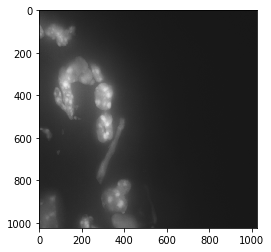

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


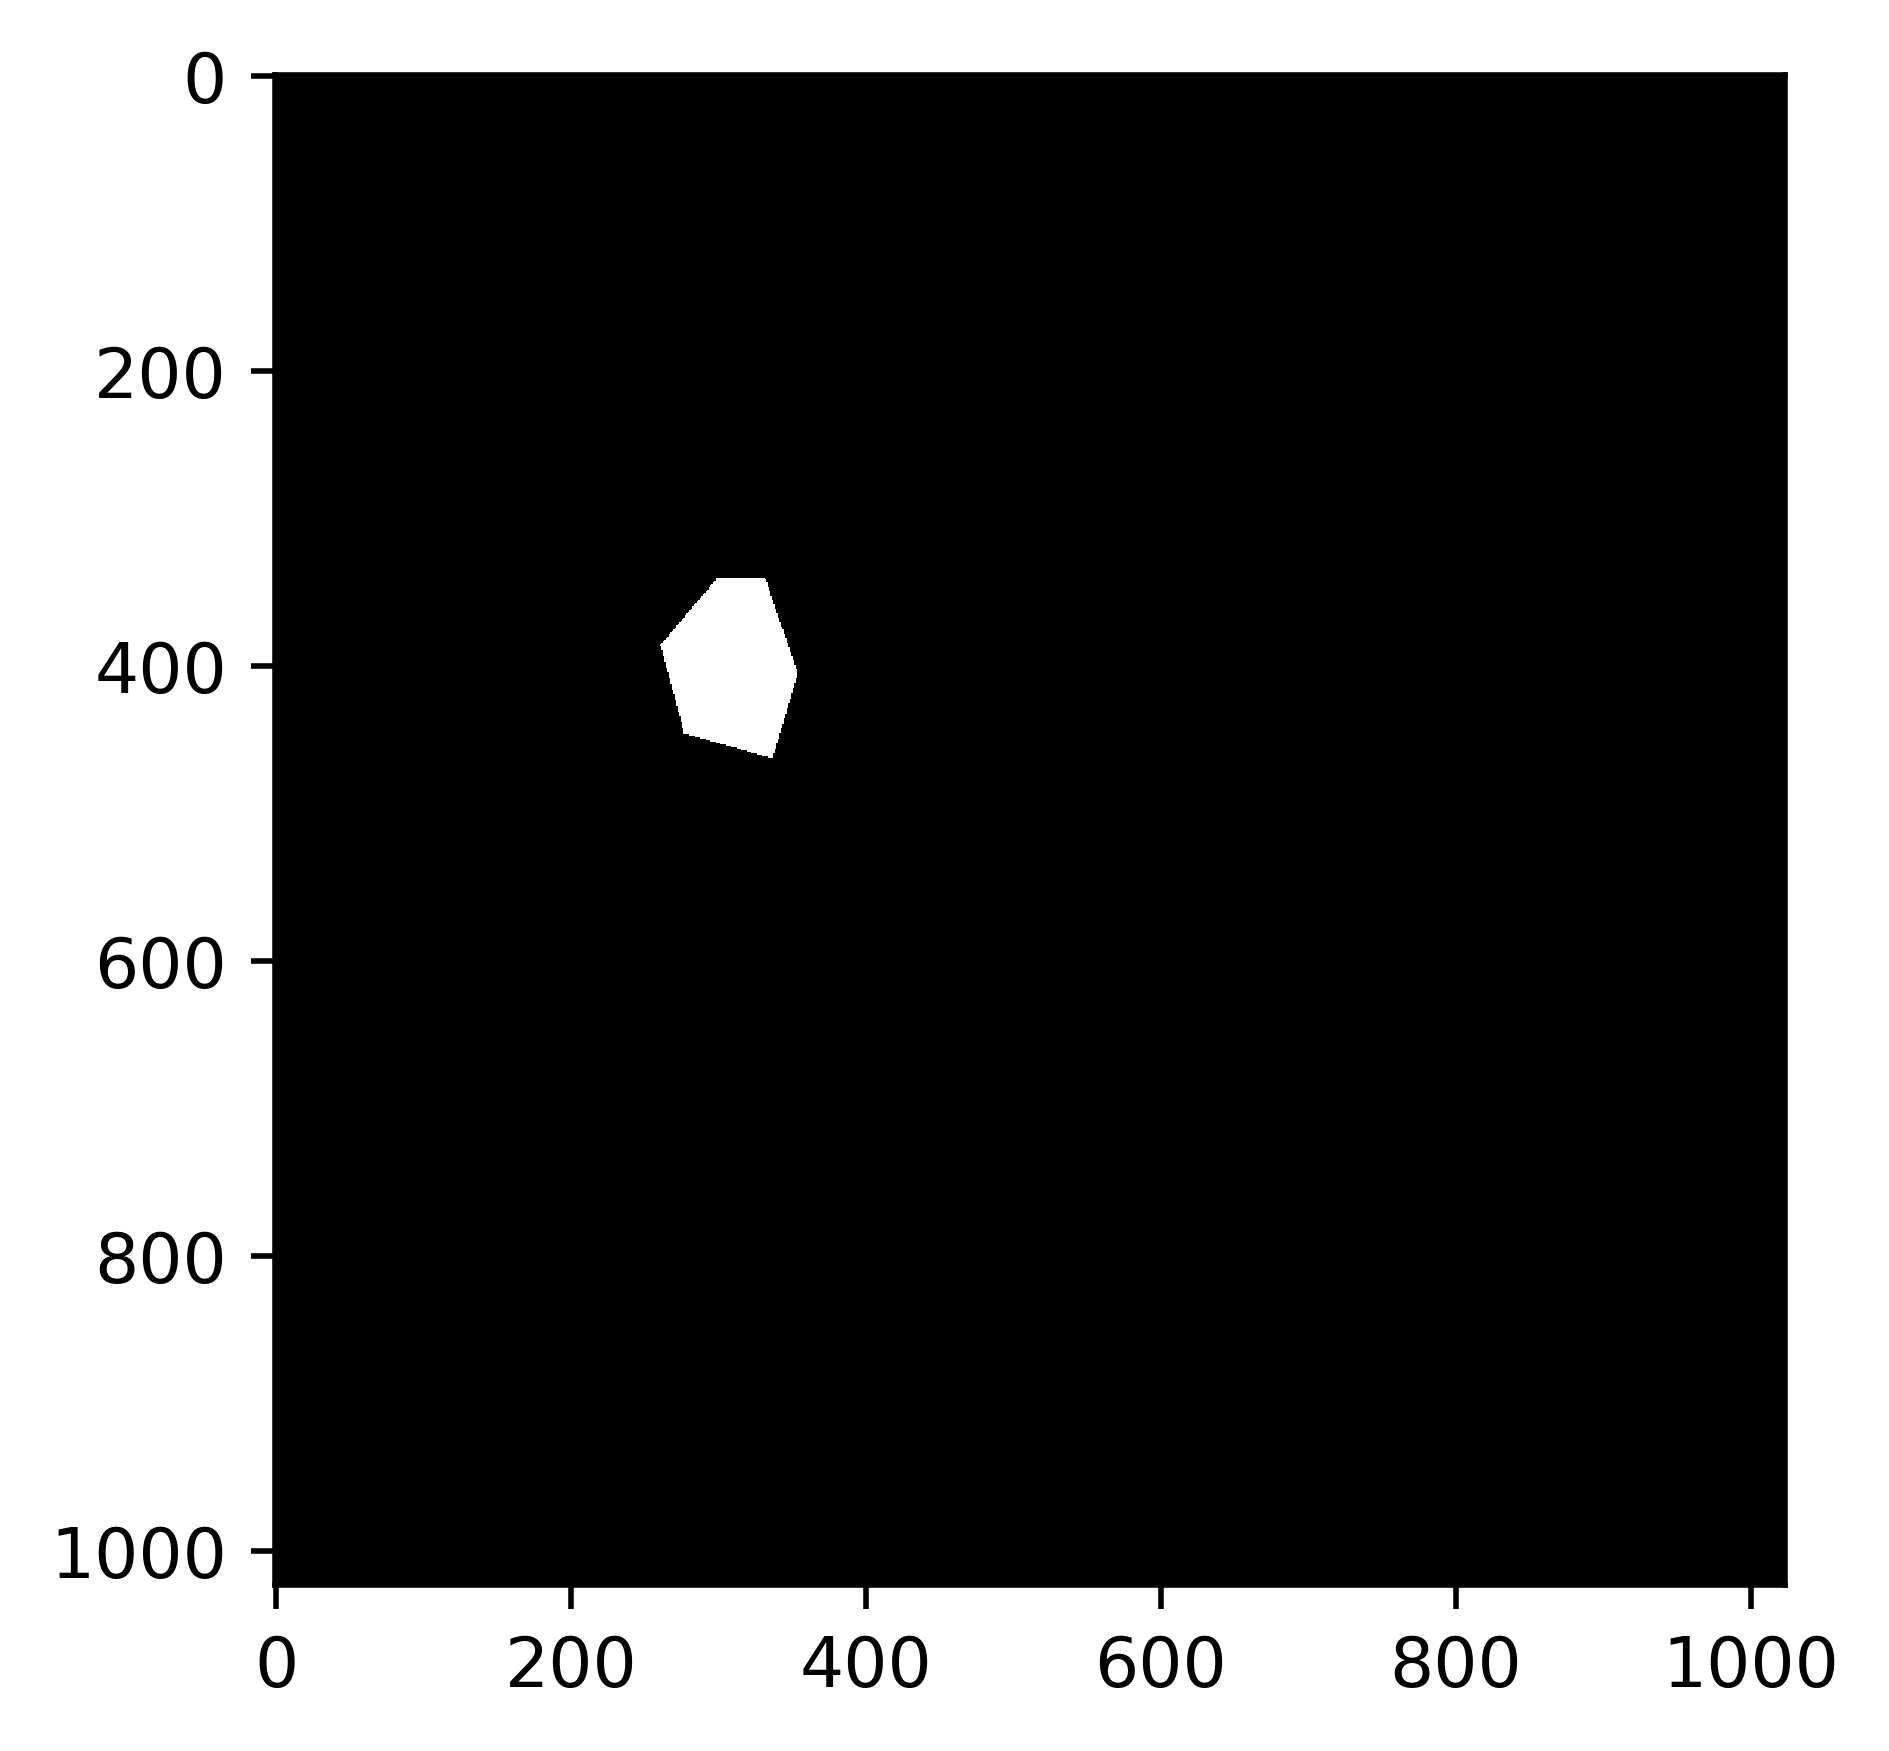

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


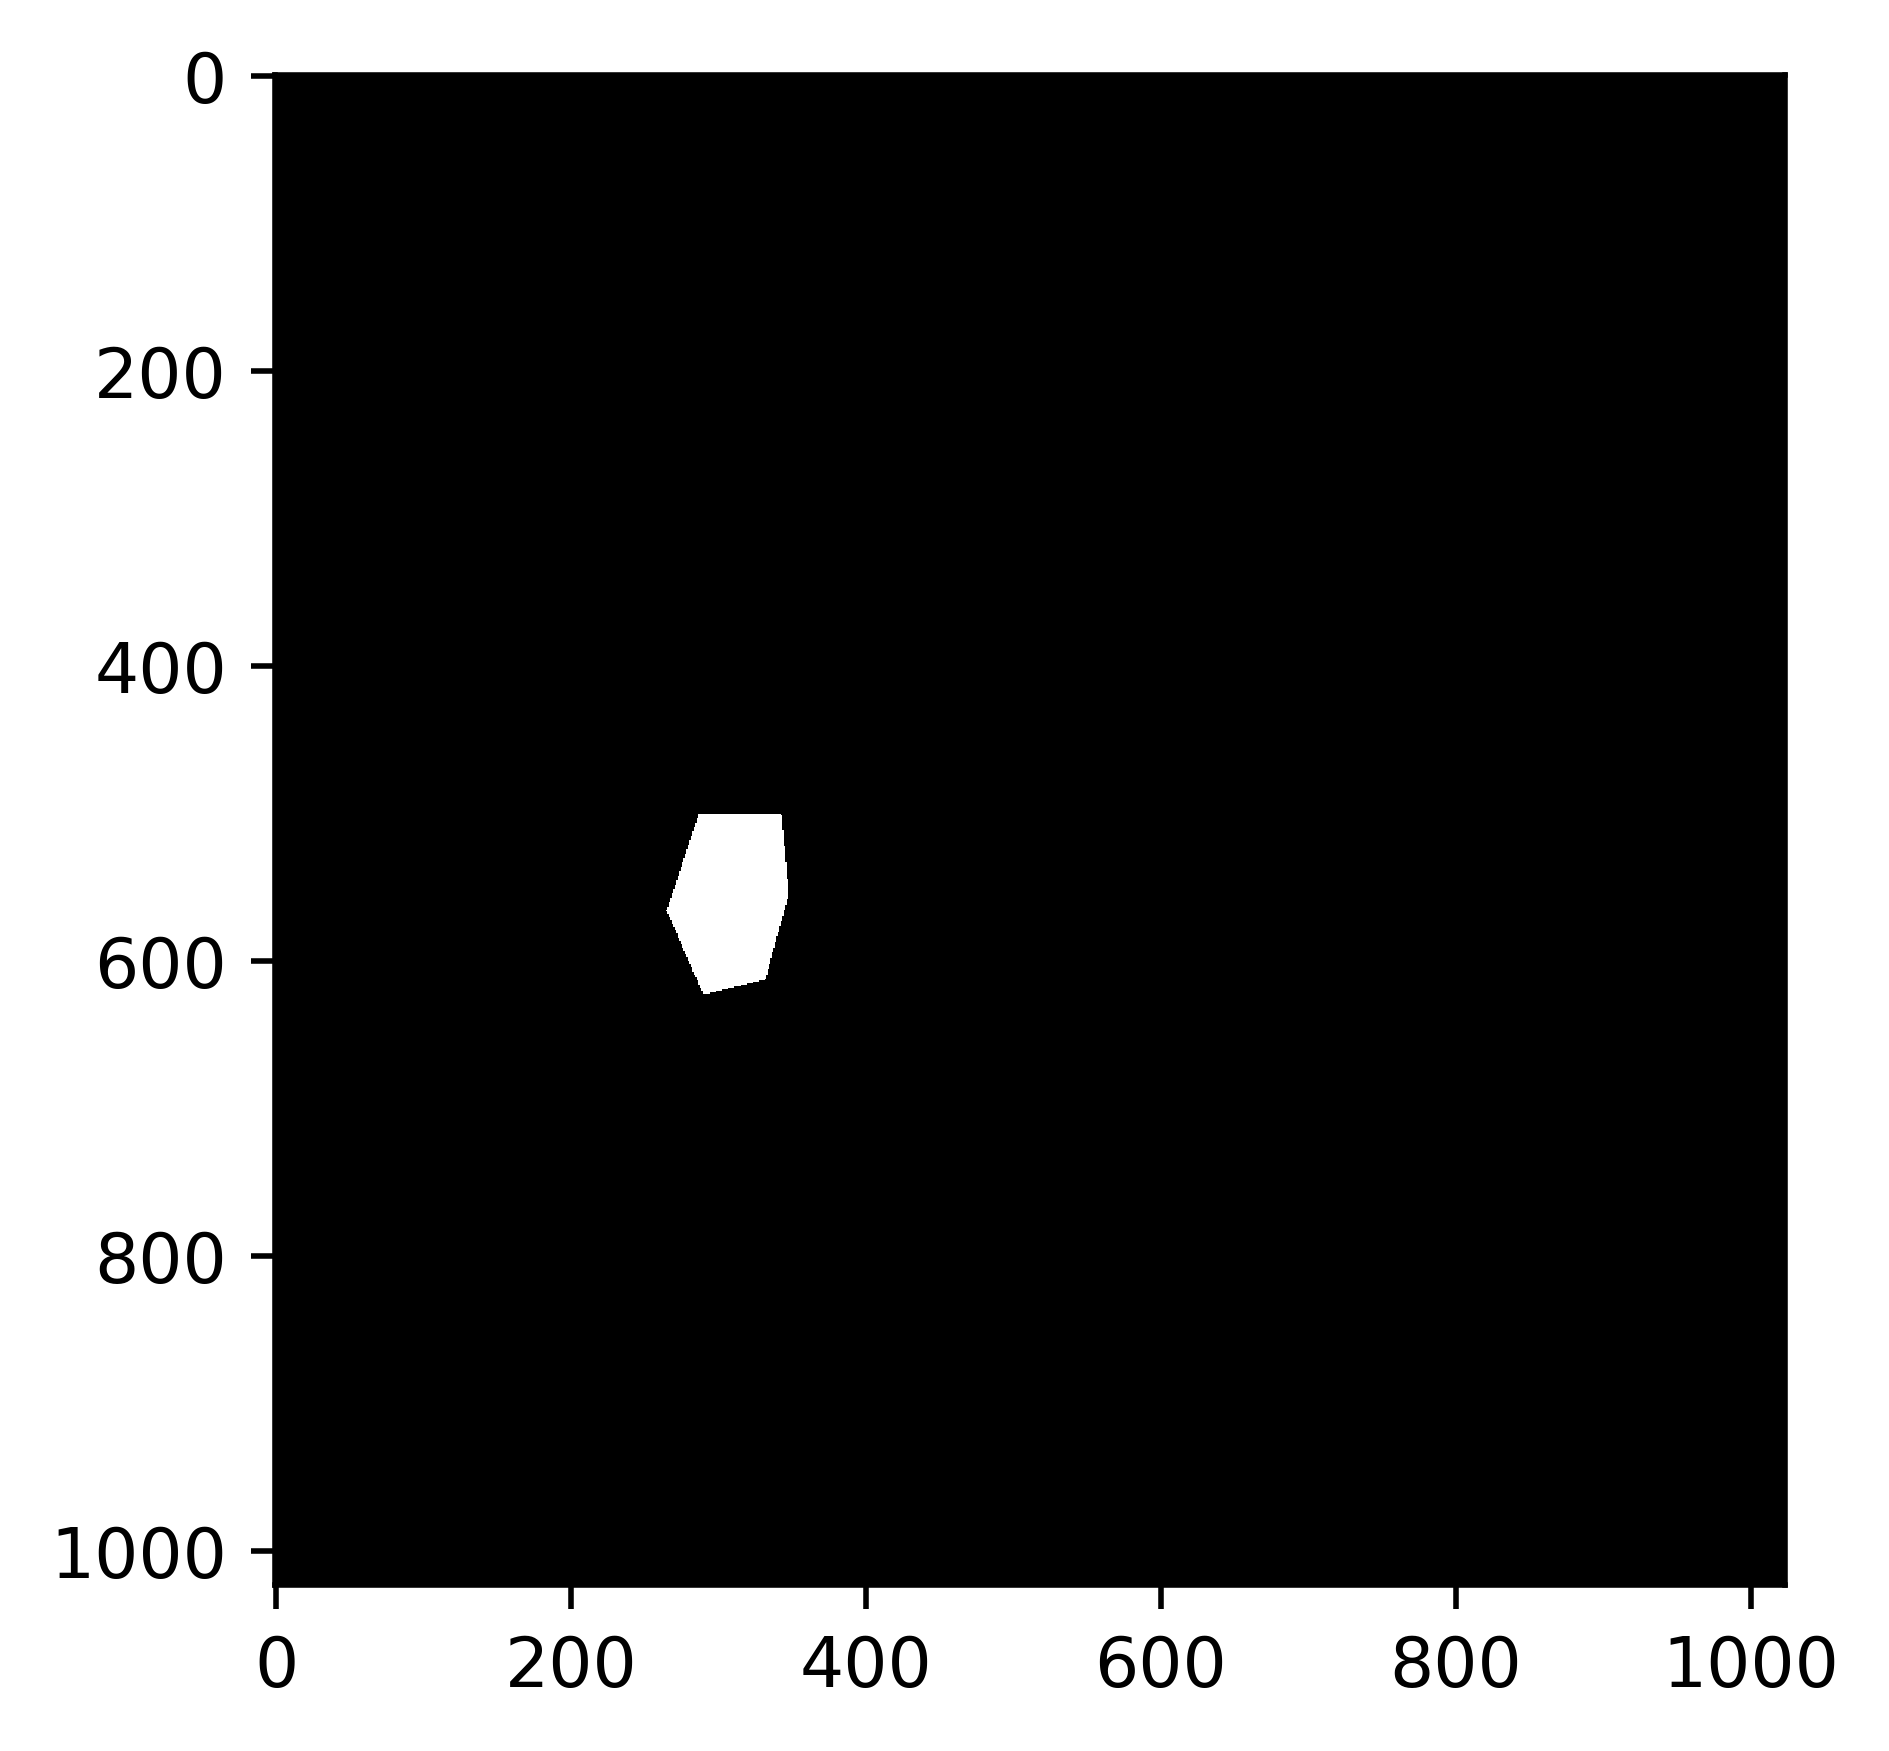

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


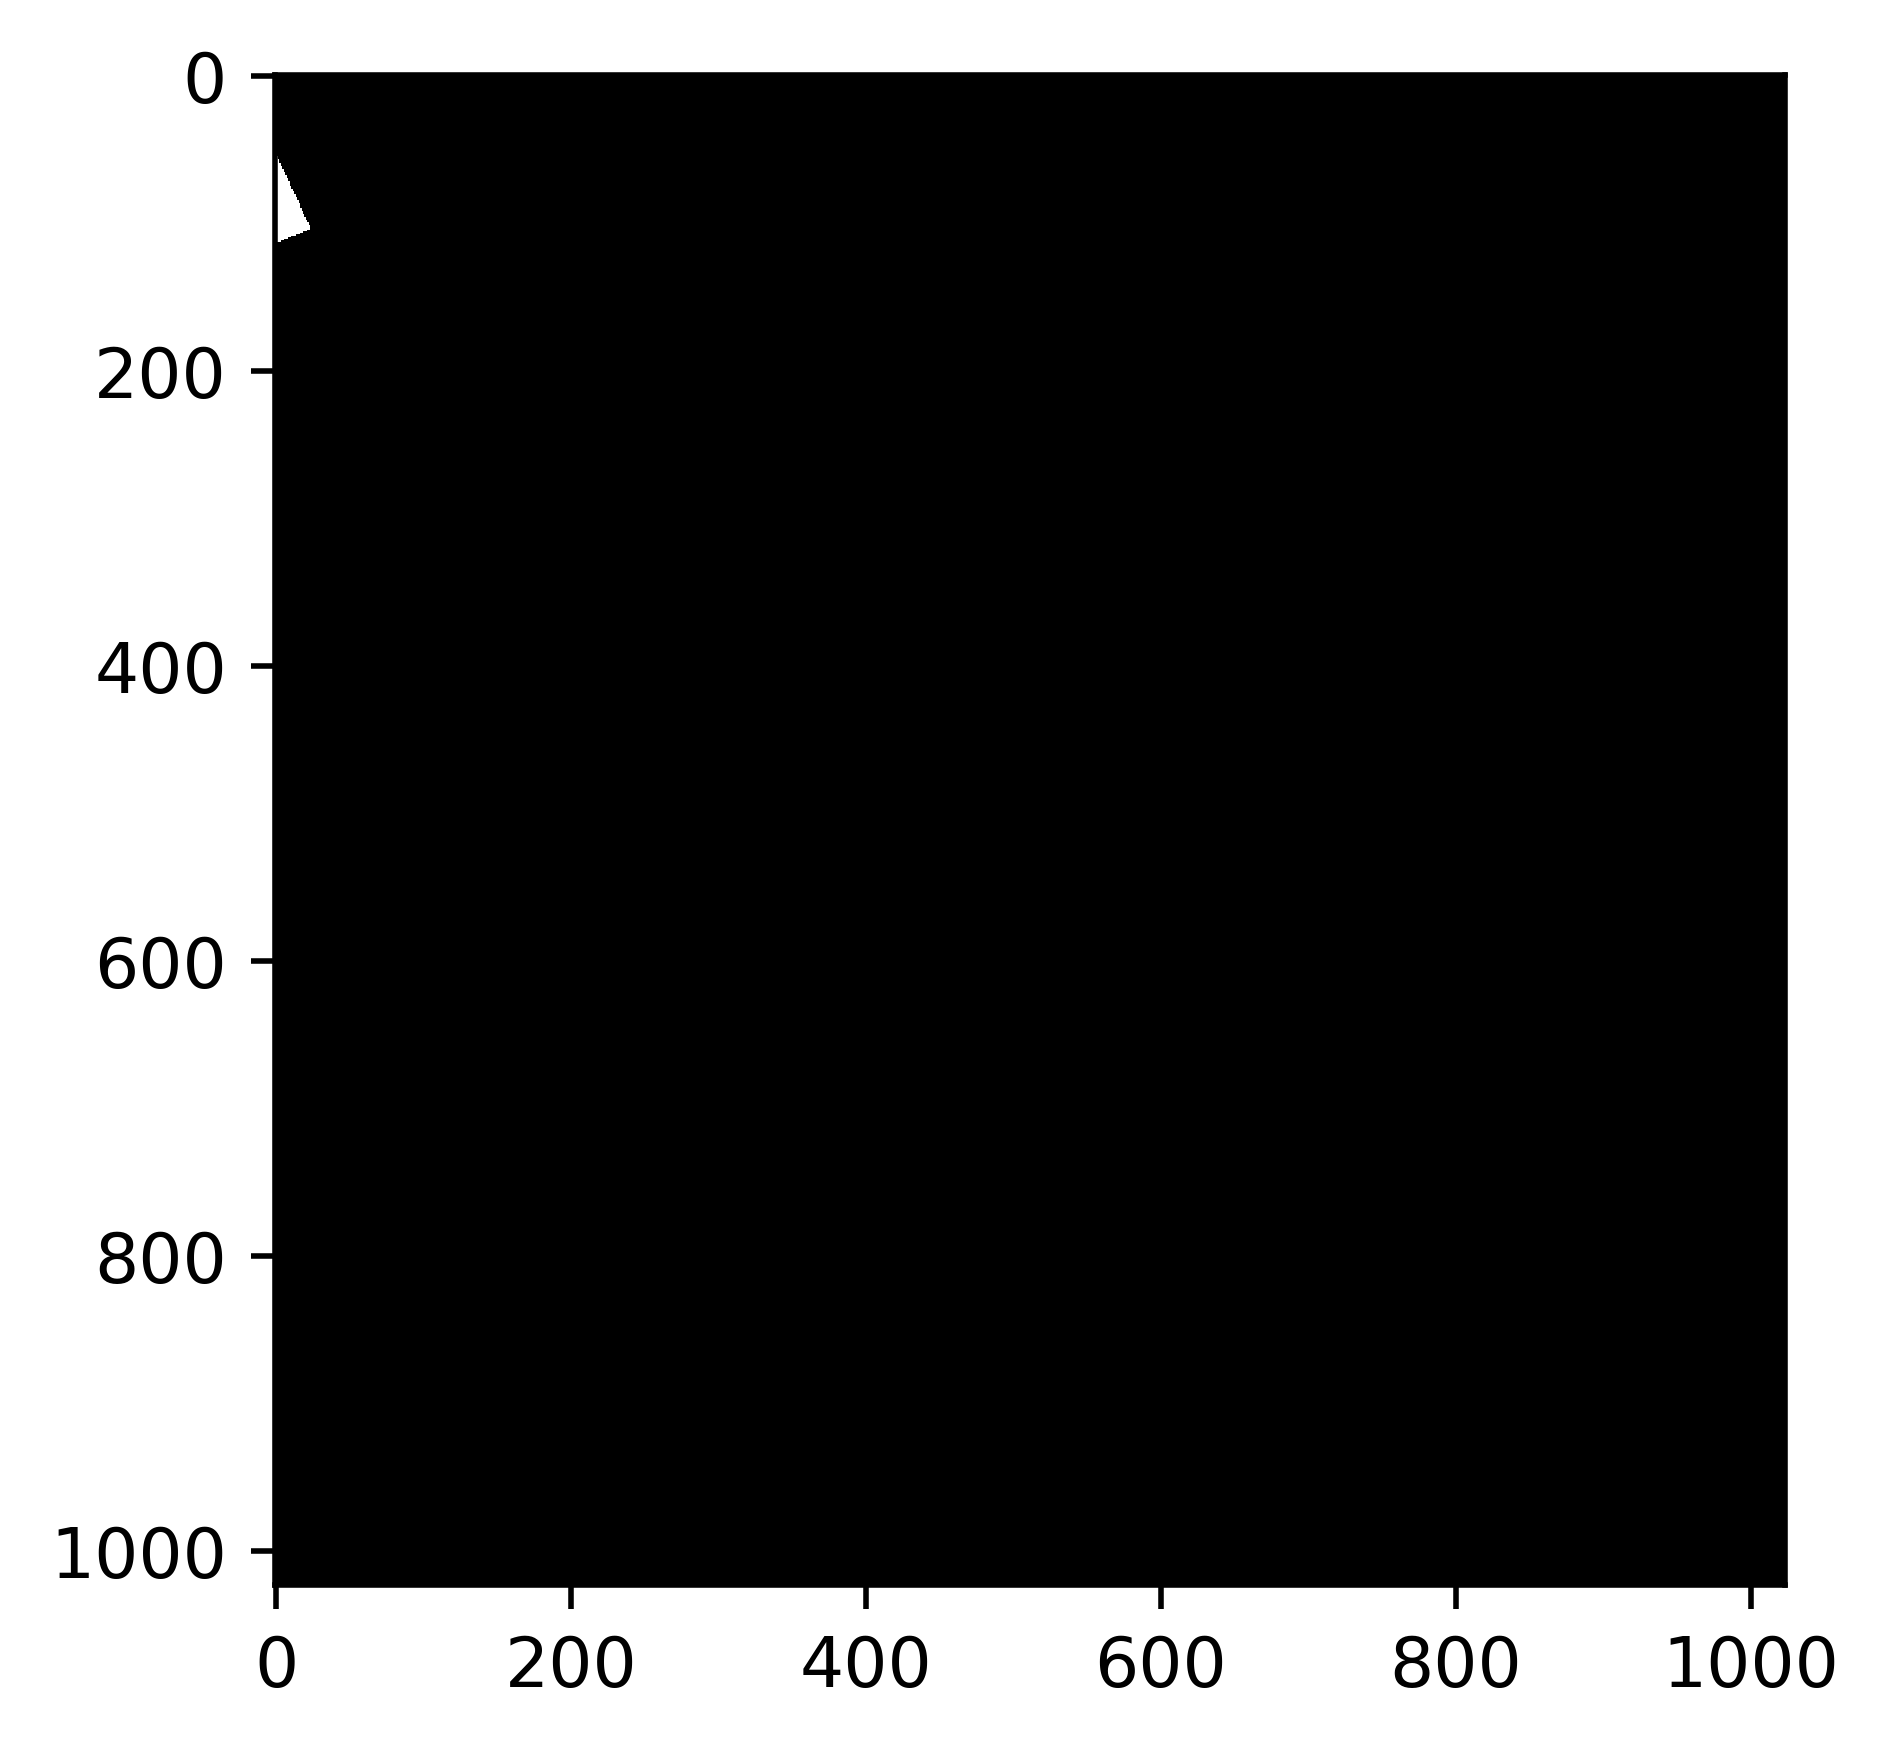

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


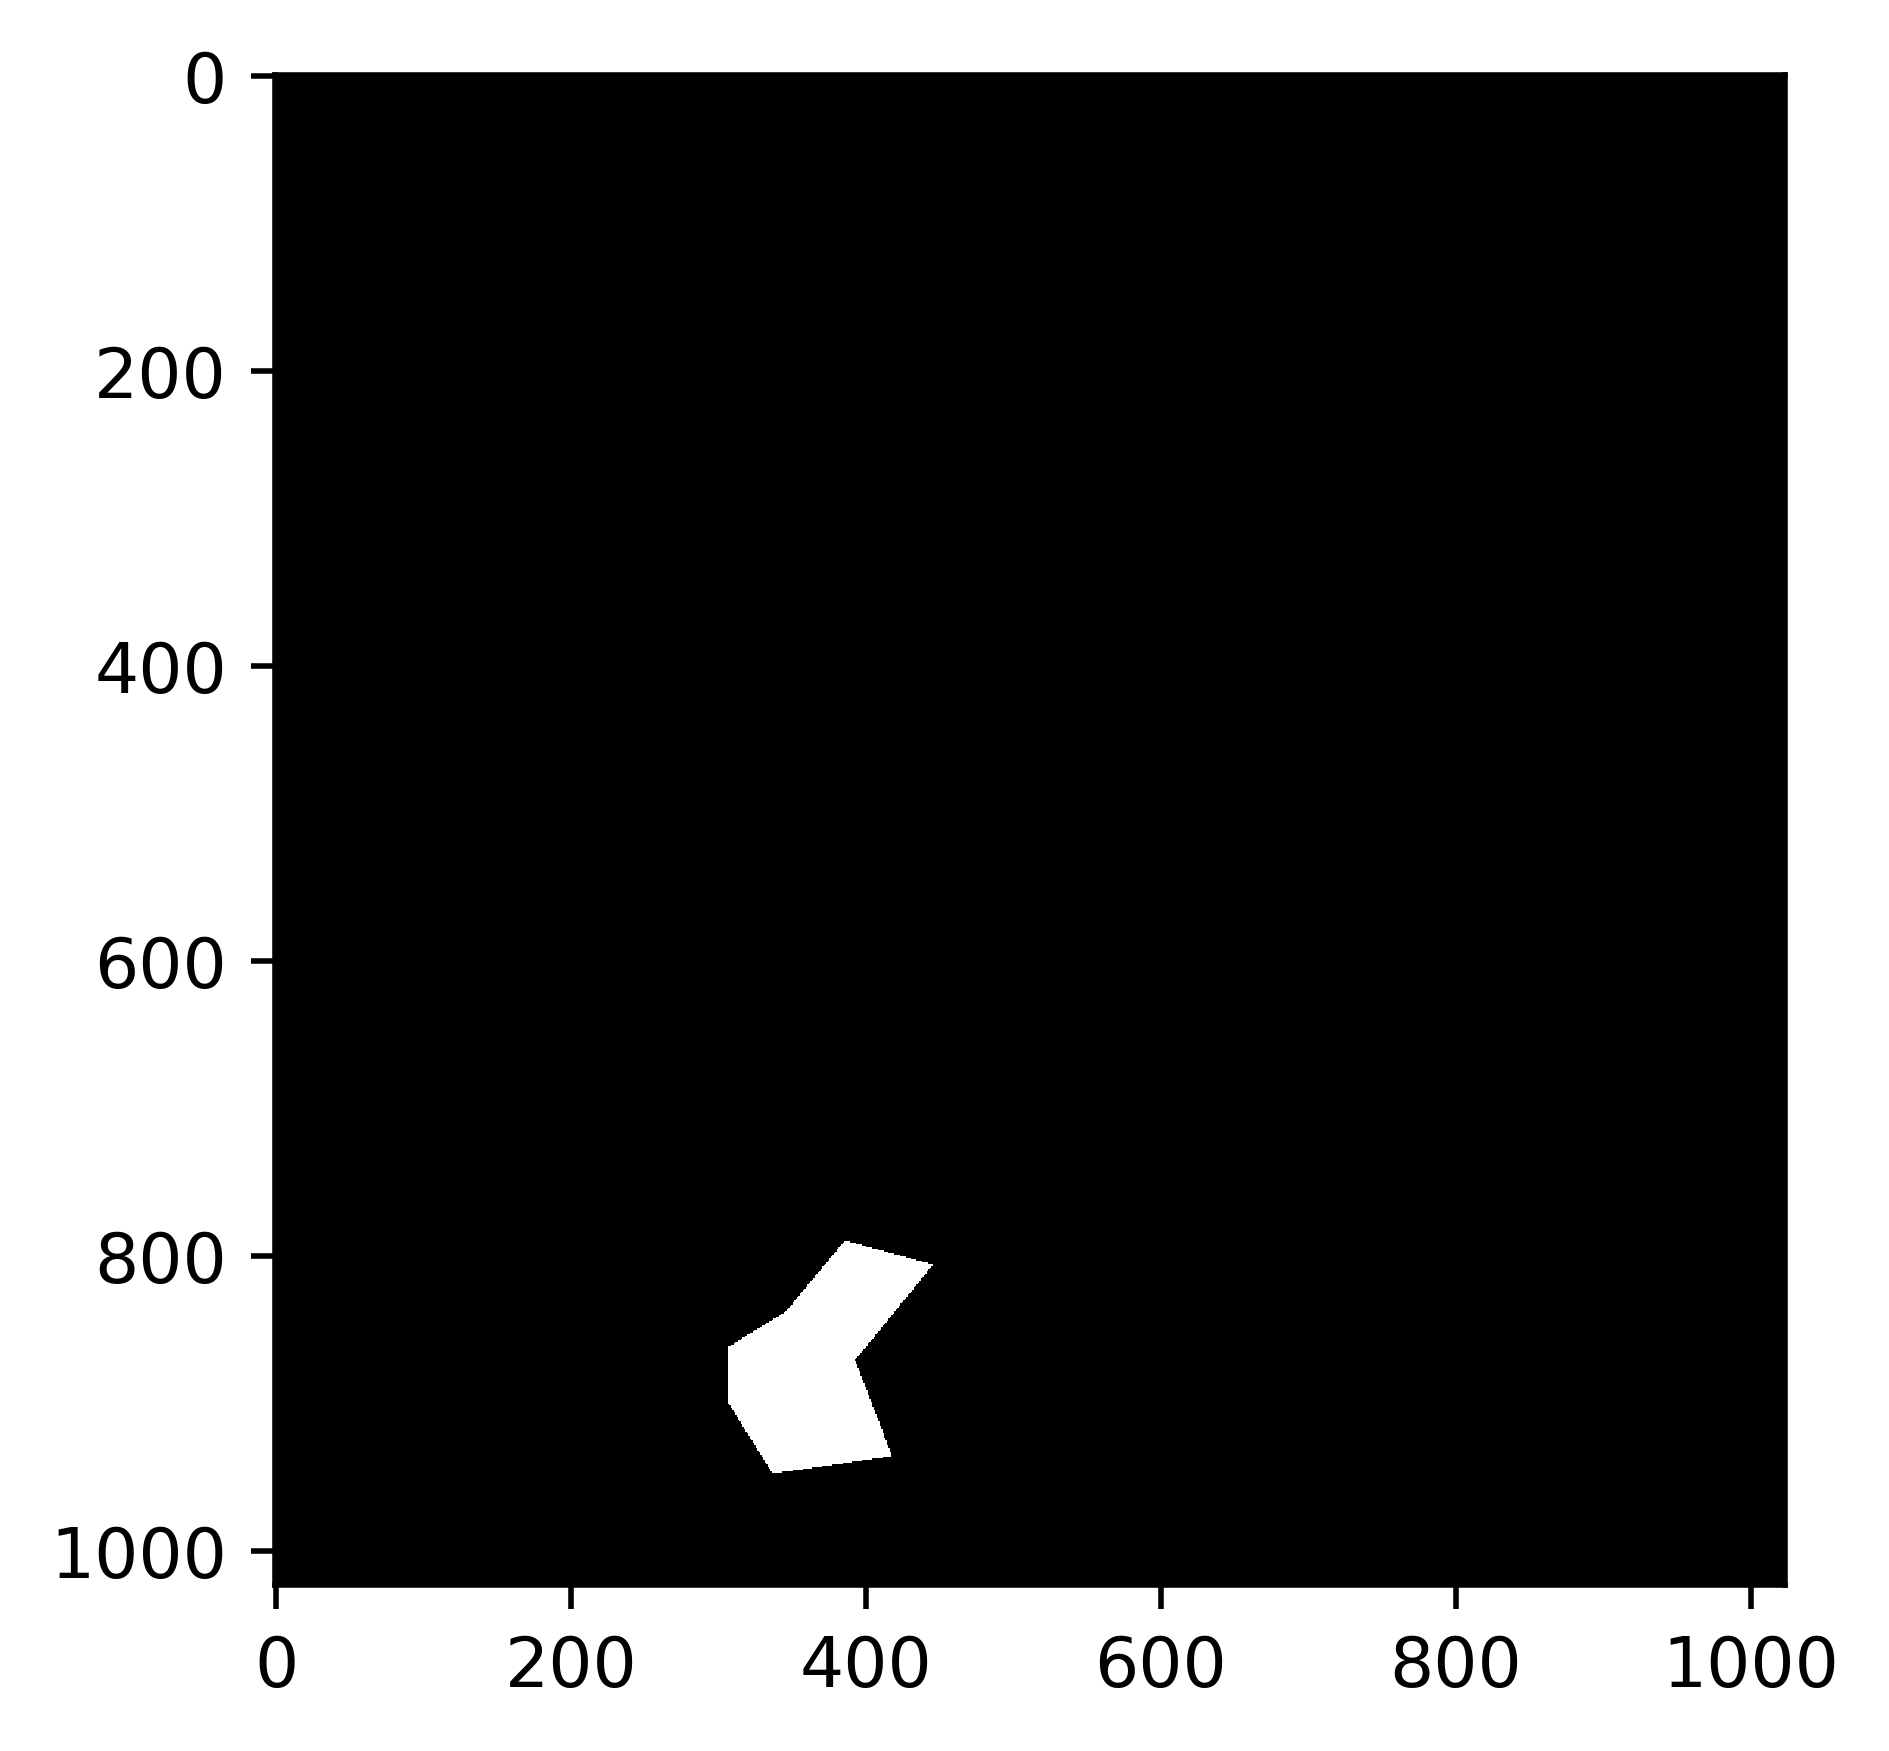

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


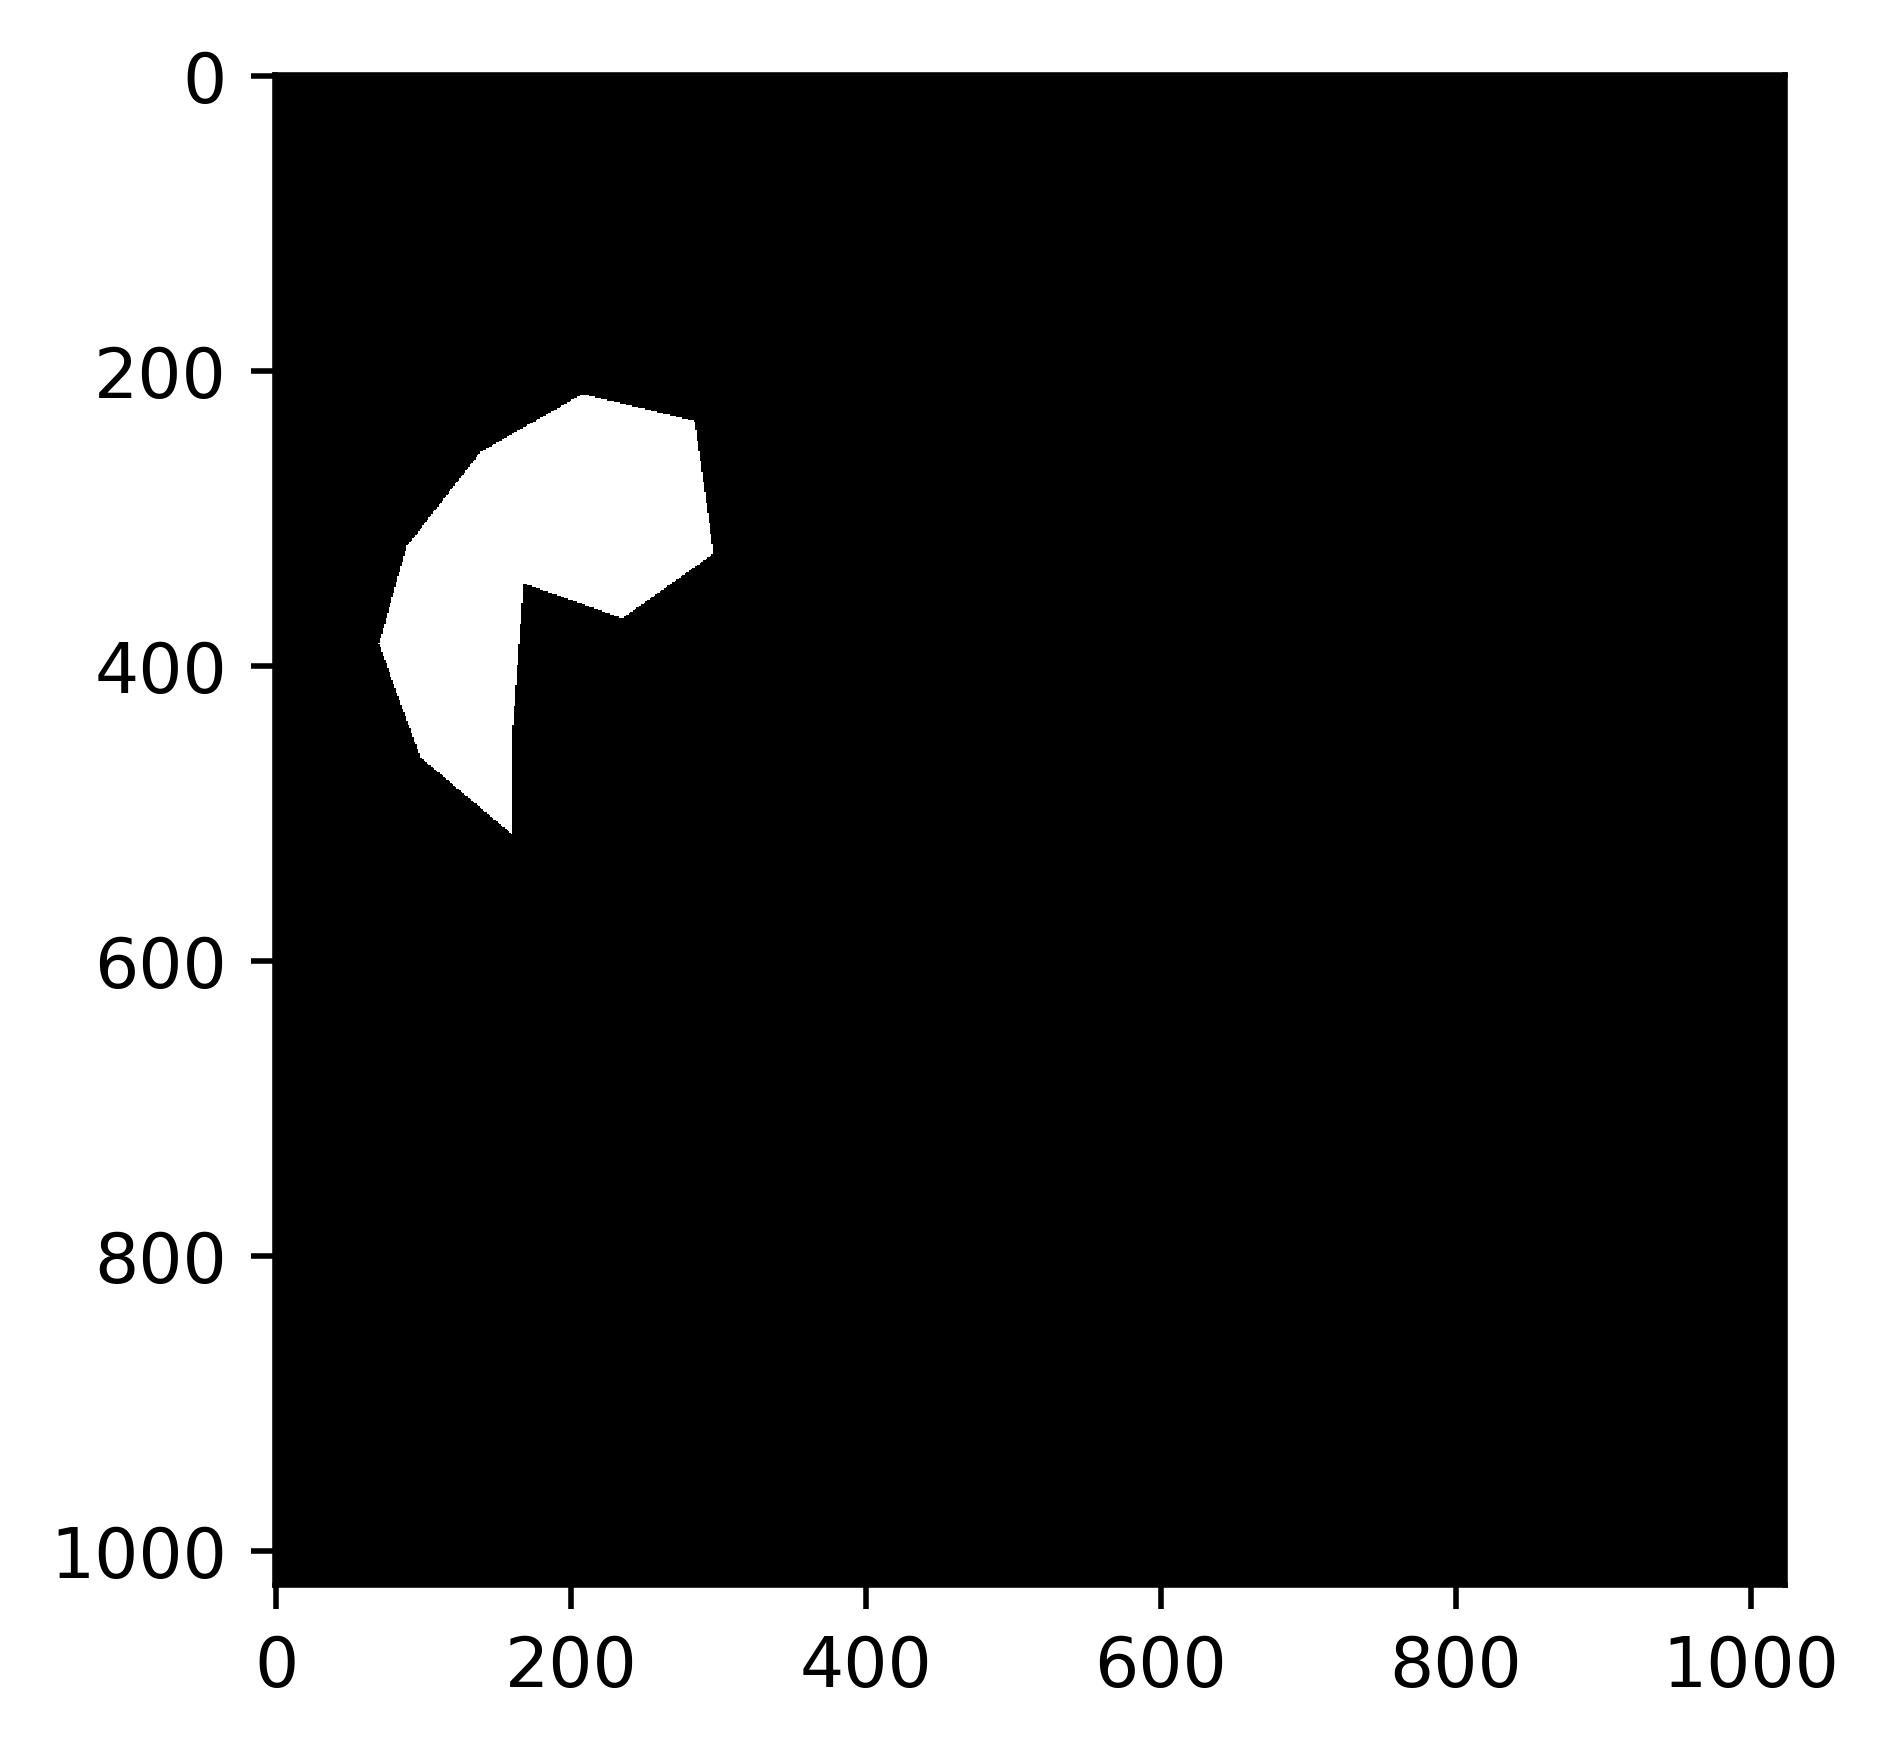

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


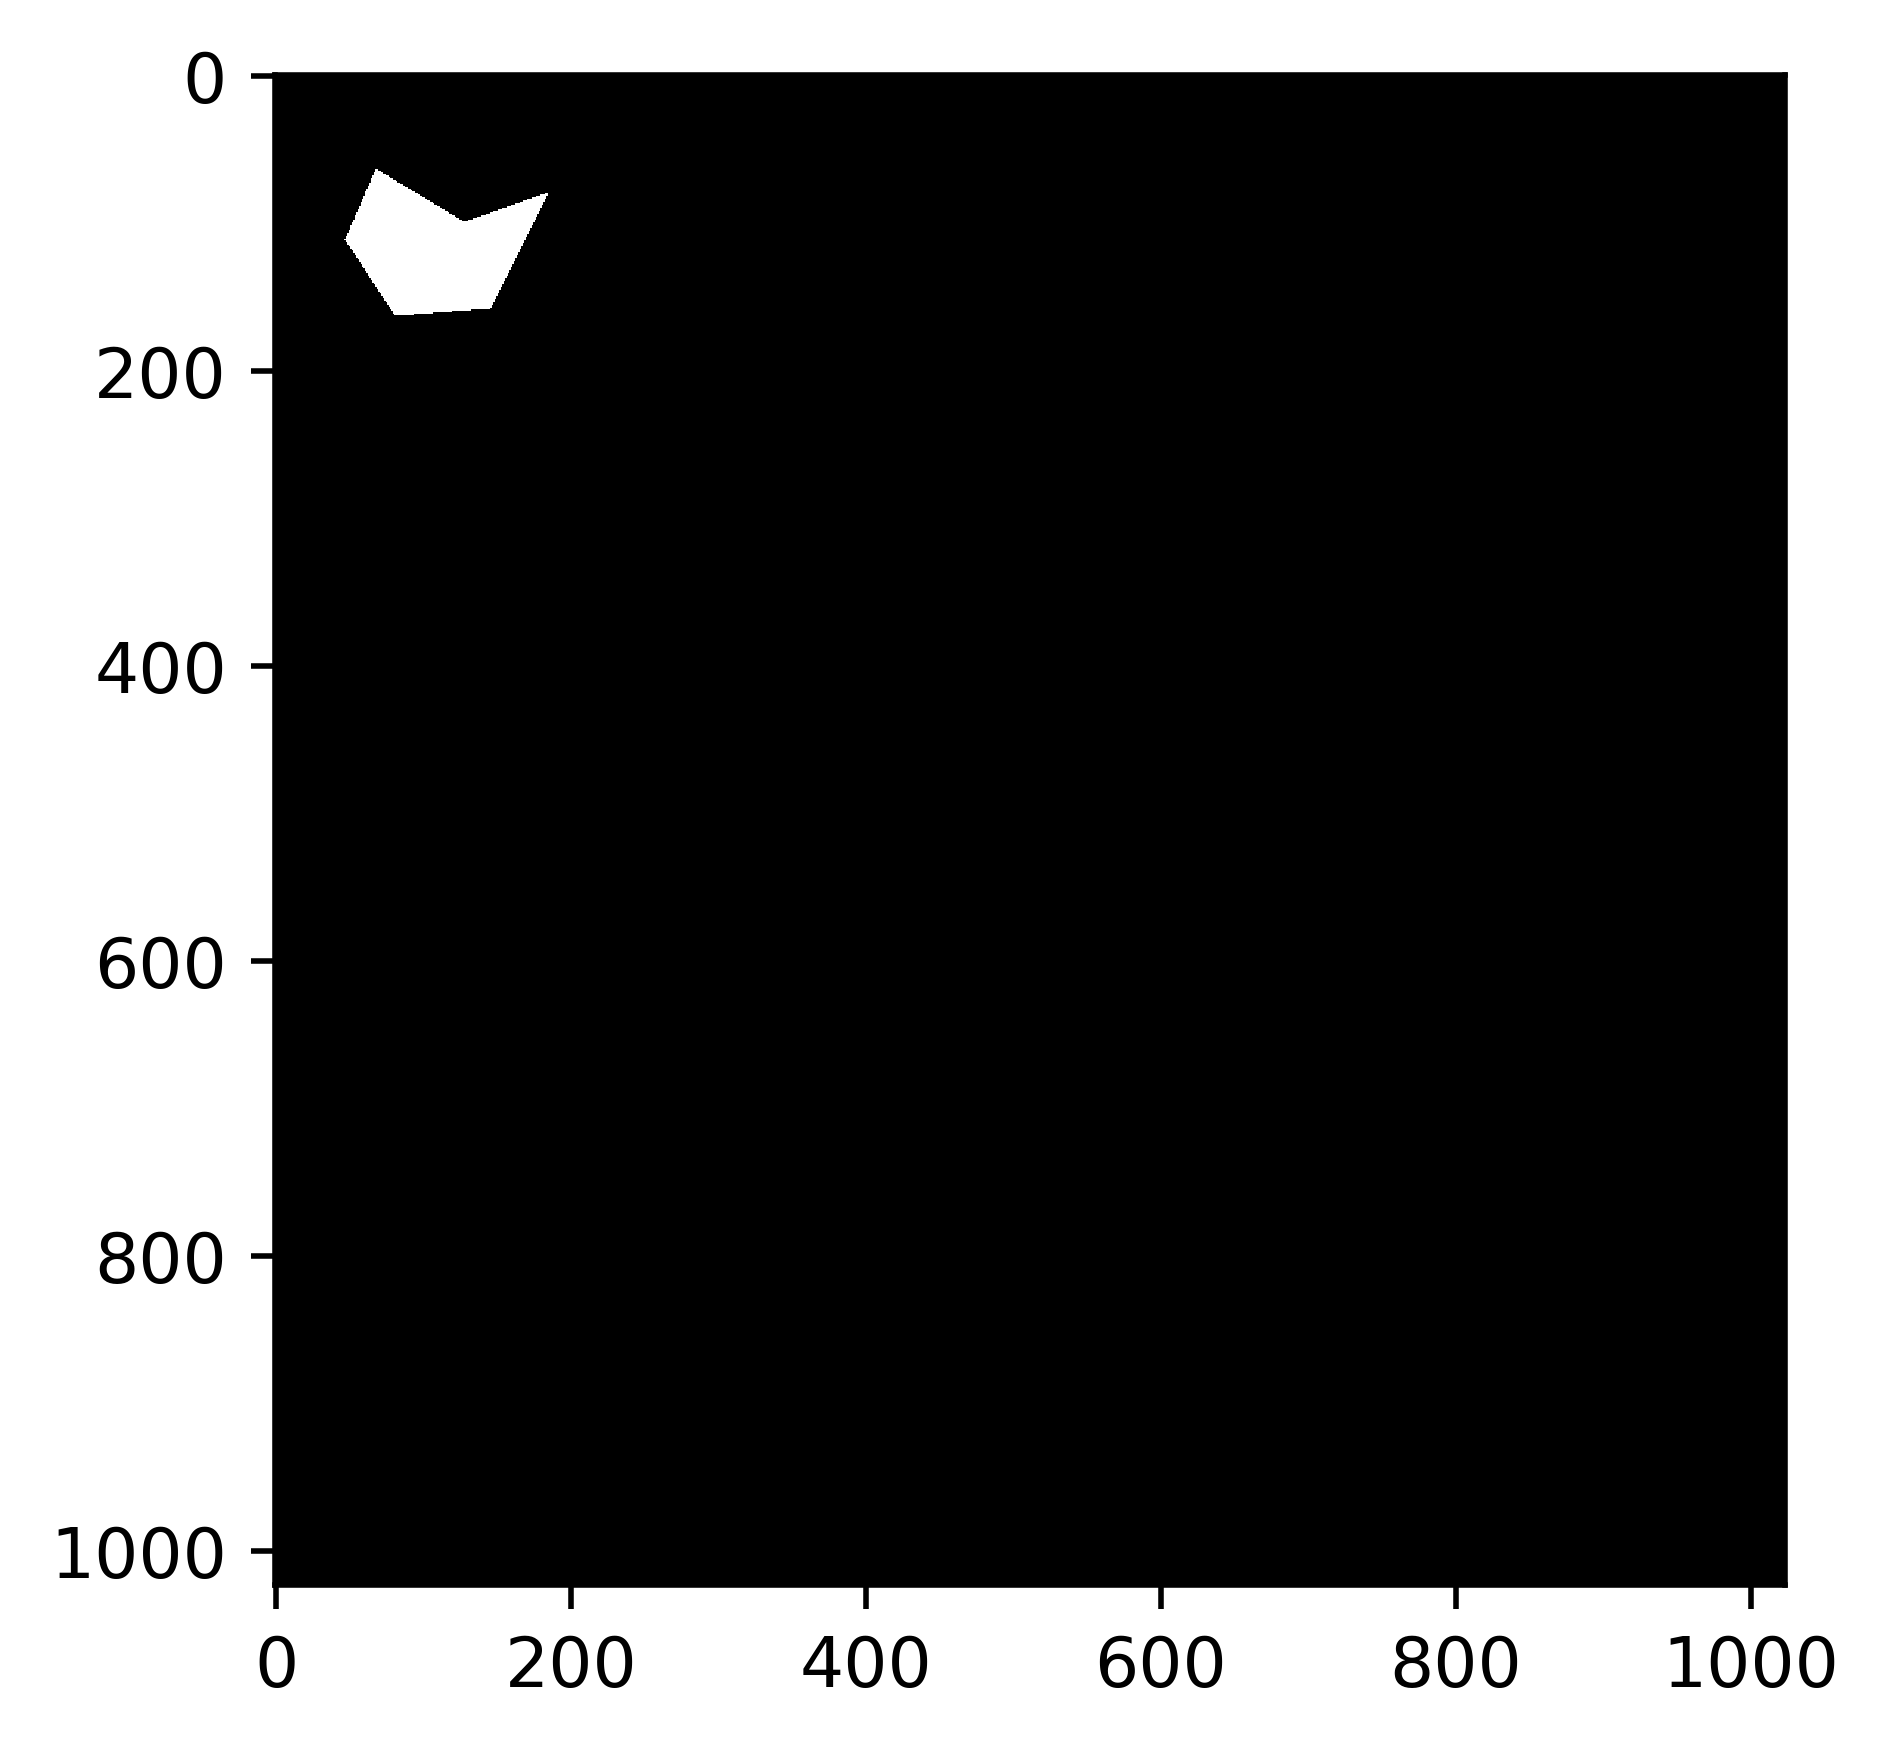

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


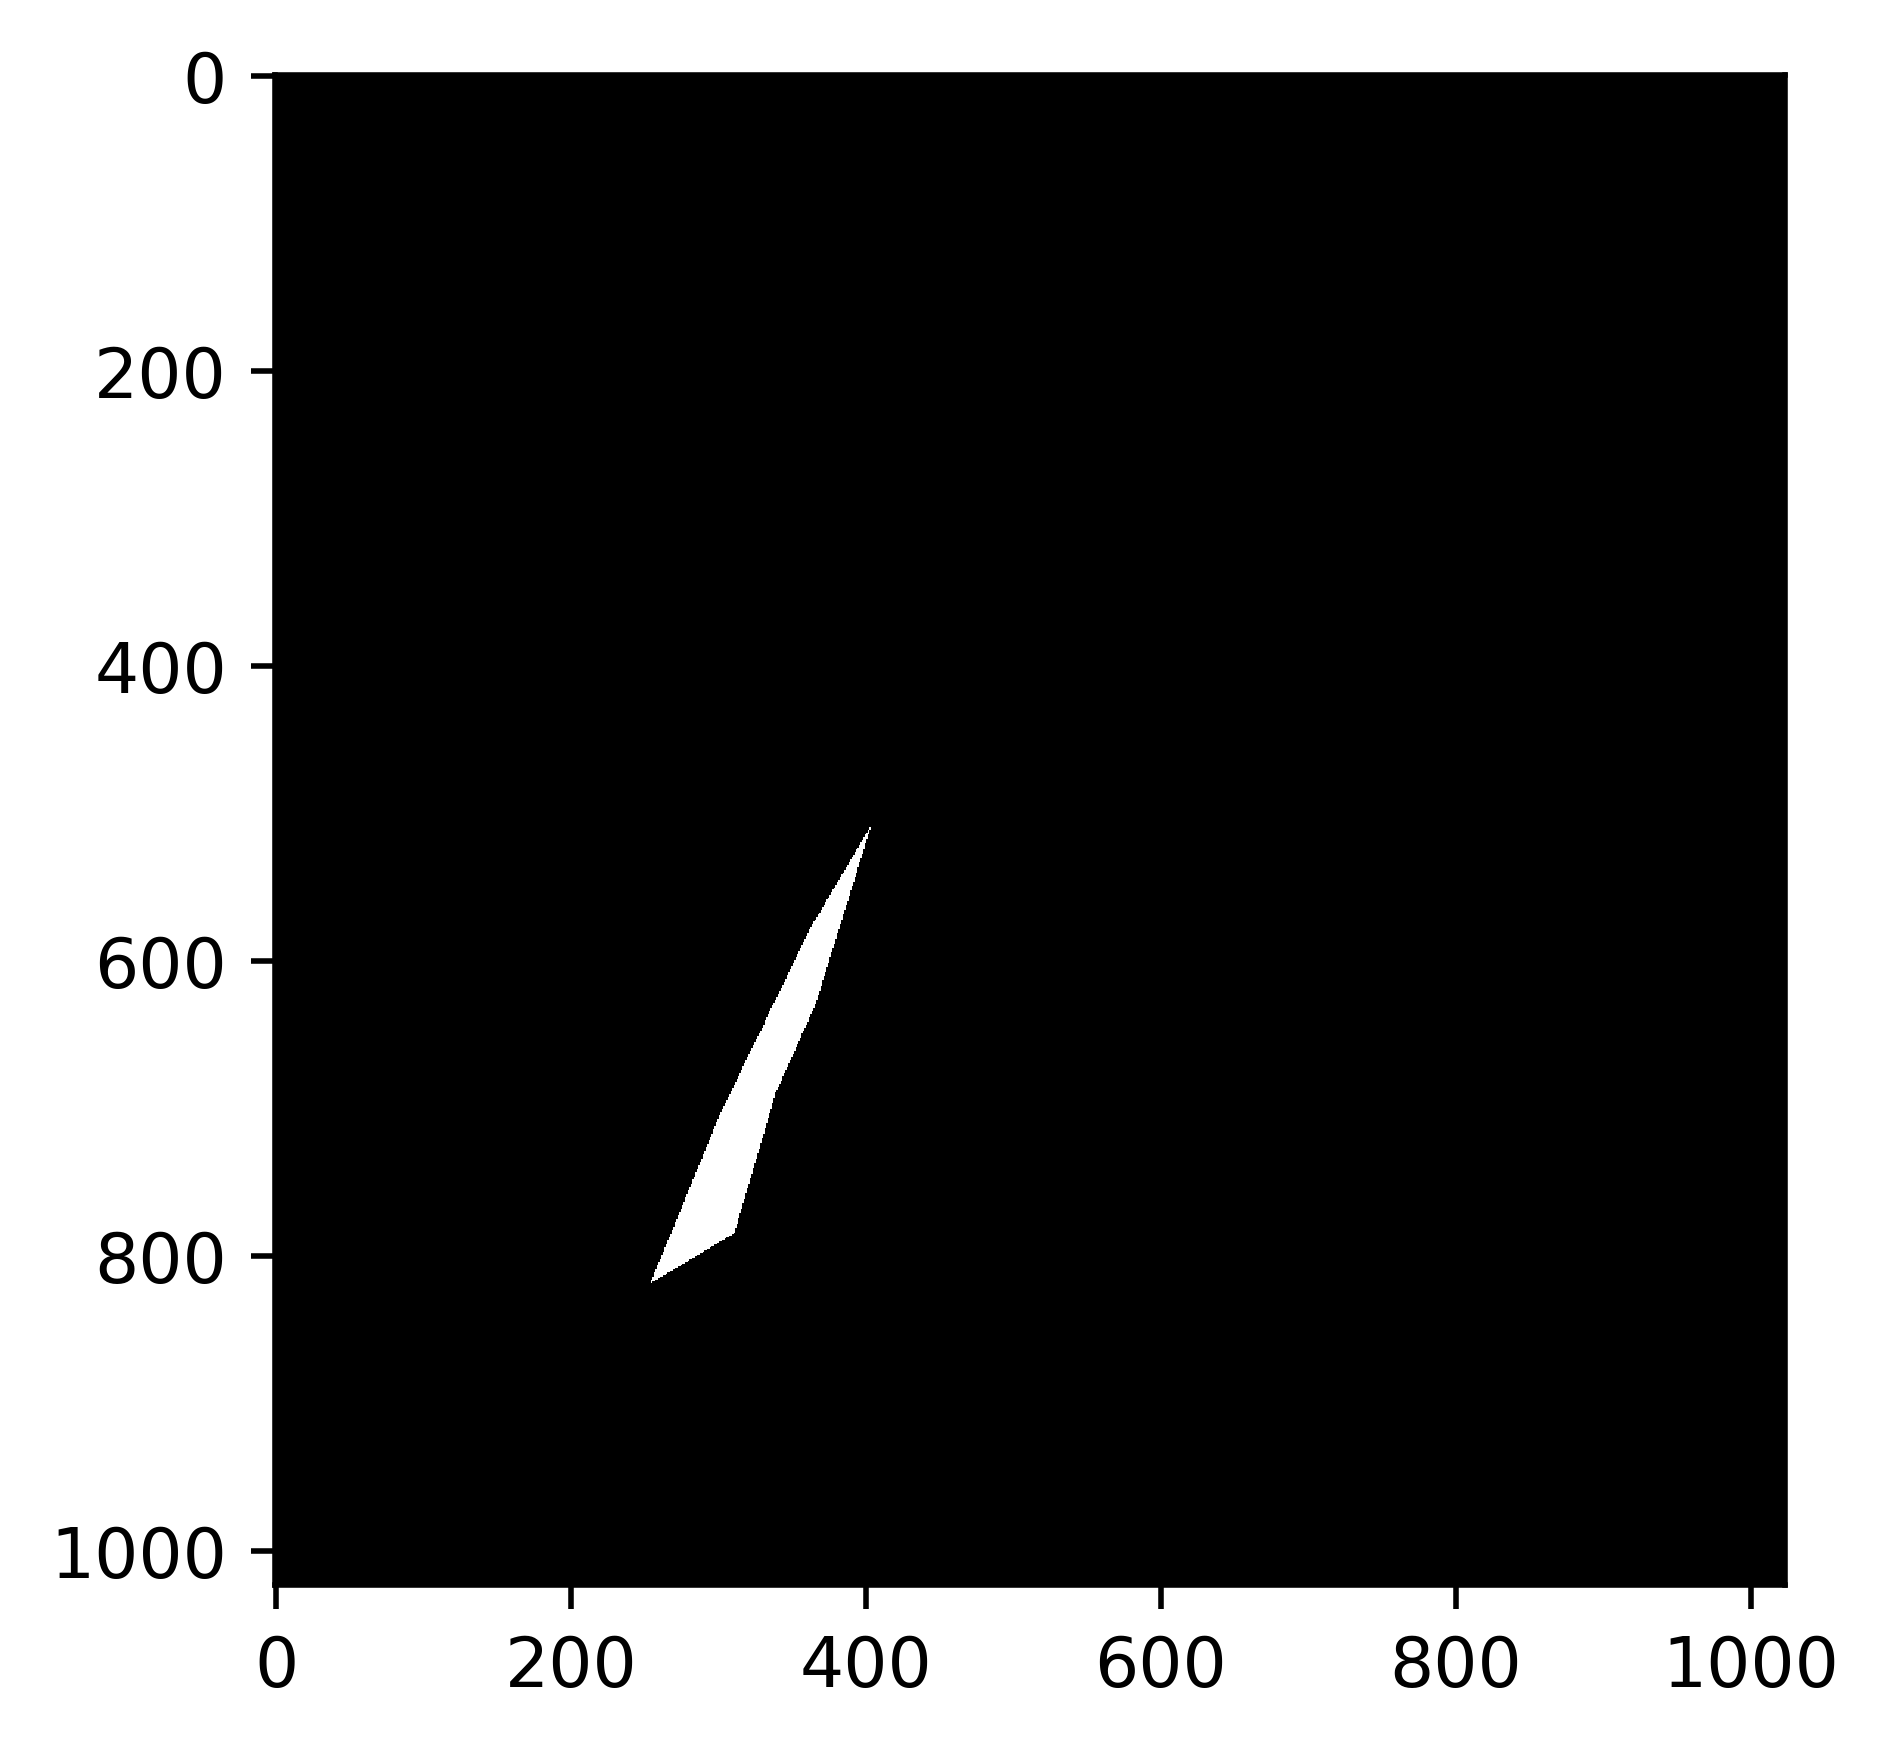

OSError: Failed to interpret file '/home/maxsen/DEEPL/data/training_data/test/Nuclei_SN_Hyb2_pos_1163.png' as a pickle

In [54]:
import matplotlib.pyplot as plt
for file in os.listdir(CHUNKS):
    n = np.load(CHUNKS + file)
    l = np.dsplit(n,8)
    for i in range(len(l)):
        if i <= 0:
            d = np.dstack((l[i], l[i], l[i]))
            plt.imshow(d)
            plt.show()
        else: 
            d = np.dstack((l[i]*300, l[i]*300, l[i]*300))
            plt.figure(dpi=500)
            plt.imshow(d)
            plt.show()
        






# test the constructed annotation file
#data = json.load(open(anno_file))
#print(data)

# compare it to a known coco annotation file
#comp_data = json.load(open(ROOT + "annotations/new_nuclei/test_coco_id.json"))
#print("_________________________________________\n",comp_data)